# Recreating Feels Like temperatures with an ANN

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import copy

Let's load in our ASOS station dataset.

In [4]:
input_data = pd.read_csv("./al_asos_jul_23_v2.csv")

In [5]:
input_data

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,mslp,p01m,p01i,gust,skyc1,skyl1
0,HEY,2023-07-01 00:11,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.0,0.0000,0.0000,NaN,CLR,NaN
1,SXS,2023-07-01 00:12,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.6,0.0000,0.0000,NaN,CLR,NaN
2,HUA,2023-07-01 00:14,89.6,32.00,77.0,25.00,66.55,102.54,5.0,1013.9,0.0000,0.0000,NaN,FEW,4700.0
3,8A0,2023-07-01 00:15,86.0,30.00,73.4,23.00,66.15,93.45,0.0,NaN,0.0000,0.0000,NaN,CLR,NaN
4,4A6,2023-07-01 00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64232,EKY,2023-07-30 23:56,79.0,26.11,76.0,24.44,90.55,79.00,0.0,1001.8,0.0000,0.0000,NaN,CLR,NaN
64233,79J,2023-07-30 23:56,76.0,24.44,73.0,22.78,90.44,76.00,4.0,1015.6,0.0000,0.0000,NaN,CLR,NaN
64234,SXS,2023-07-30 23:56,73.4,23.00,73.4,23.00,100.00,73.40,0.0,1015.1,0.0000,0.0000,NaN,FEW,500.0
64235,EUF,2023-07-30 23:58,79.0,26.11,75.0,23.89,87.58,79.00,0.0,1014.3,0.0000,0.0000,NaN,CLR,NaN


In [6]:
# It is often good practice to drop missing data, so let's do just that. 
input_data_nona = input_data.dropna()

In [7]:
input_data_nona

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,mslp,p01m,p01i,gust,skyc1,skyl1
290,HSV,2023-07-01 03:53,81.0,27.22,68.0,20.00,64.69,83.76,24.0,1017.4,0.0001,0.0001,36.0,FEW,900.0
299,DCU,2023-07-01 03:53,81.0,27.22,67.0,19.44,62.28,83.40,16.0,1017.5,0.0000,0.0000,31.0,FEW,4700.0
406,1M4,2023-07-01 04:56,79.0,26.11,75.0,23.89,87.58,79.00,11.0,1017.1,0.0000,0.0000,19.0,FEW,3000.0
1378,PRN,2023-07-01 16:58,91.0,32.78,73.0,22.78,55.72,99.57,5.0,1011.7,0.0000,0.0000,14.0,FEW,3700.0
1433,BHM,2023-07-01 17:53,96.0,35.56,73.0,22.78,47.57,106.07,12.0,1015.5,0.0000,0.0000,17.0,BKN,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64061,LOR,2023-07-30 22:27,78.8,26.00,71.6,22.00,78.62,78.80,8.0,1014.4,0.0000,0.0000,16.0,SCT,2100.0
64065,HEY,2023-07-30 22:32,80.6,27.00,71.6,22.00,74.11,84.57,6.0,1015.5,0.0000,0.0000,16.0,FEW,2000.0
64084,OZR,2023-07-30 22:37,77.0,25.00,71.6,22.00,83.44,77.00,9.0,1015.9,0.0000,0.0000,18.0,SCT,3000.0
64109,BFM,2023-07-30 22:53,80.0,26.67,73.0,22.78,79.25,84.13,5.0,1016.5,1.7800,0.0700,20.0,BKN,5000.0


583 rows!?! That's not enough. Remember to be careful as you're doing this...

In [8]:
input_data_nona = input_data.drop('gust', axis=1).dropna()

In [10]:
input_data_nona

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,mslp,p01m,p01i,skyc1,skyl1
2,HUA,2023-07-01 00:14,89.6,32.00,77.0,25.00,66.55,102.54,5.0,1013.9,0.0000,0.0000,FEW,4700.0
22,HUA,2023-07-01 00:25,89.6,32.00,77.0,25.00,66.55,102.54,5.0,1013.9,0.0000,0.0000,FEW,4700.0
46,BHM,2023-07-01 00:53,93.0,33.89,71.0,21.67,49.09,100.13,10.0,1014.2,0.0000,0.0000,FEW,15000.0
49,HSV,2023-07-01 00:53,89.0,31.67,78.0,25.56,70.12,103.36,3.0,1013.8,0.0000,0.0000,FEW,5500.0
72,HUA,2023-07-01 00:55,88.3,31.28,77.7,25.39,70.97,101.60,4.0,1013.9,0.0001,0.0001,BKN,4400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64217,SXS,2023-07-30 23:55,74.0,23.33,73.6,23.11,98.66,74.00,0.0,1014.7,0.2500,0.0100,FEW,700.0
64227,HEY,2023-07-30 23:55,77.5,25.28,75.0,23.89,92.02,77.50,0.0,1014.1,0.0001,0.0001,SCT,9500.0
64228,LOR,2023-07-30 23:55,75.4,24.11,73.2,22.89,92.89,75.40,3.0,1013.7,0.0001,0.0001,FEW,9000.0
64230,MOB,2023-07-30 23:56,82.0,27.78,72.0,22.22,71.78,86.83,14.0,1016.1,0.0001,0.0001,BKN,4100.0


See any issues here?

In [11]:
input_data_renamed_clouds = copy.deepcopy(input_data)
all_cloud_vals = input_data_renamed_clouds['skyc1']
all_cloud_vals.fillna('CLR')
input_data_renamed_clouds['skyc1'] = all_cloud_vals
input_data_renamed_clouds

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,mslp,p01m,p01i,gust,skyc1,skyl1
0,HEY,2023-07-01 00:11,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.0,0.0000,0.0000,NaN,CLR,NaN
1,SXS,2023-07-01 00:12,87.8,31.00,71.6,22.00,58.78,94.18,0.0,1013.6,0.0000,0.0000,NaN,CLR,NaN
2,HUA,2023-07-01 00:14,89.6,32.00,77.0,25.00,66.55,102.54,5.0,1013.9,0.0000,0.0000,NaN,FEW,4700.0
3,8A0,2023-07-01 00:15,86.0,30.00,73.4,23.00,66.15,93.45,0.0,NaN,0.0000,0.0000,NaN,CLR,NaN
4,4A6,2023-07-01 00:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64232,EKY,2023-07-30 23:56,79.0,26.11,76.0,24.44,90.55,79.00,0.0,1001.8,0.0000,0.0000,NaN,CLR,NaN
64233,79J,2023-07-30 23:56,76.0,24.44,73.0,22.78,90.44,76.00,4.0,1015.6,0.0000,0.0000,NaN,CLR,NaN
64234,SXS,2023-07-30 23:56,73.4,23.00,73.4,23.00,100.00,73.40,0.0,1015.1,0.0000,0.0000,NaN,FEW,500.0
64235,EUF,2023-07-30 23:58,79.0,26.11,75.0,23.89,87.58,79.00,0.0,1014.3,0.0000,0.0000,NaN,CLR,NaN


In [31]:
input_data_nona = input_data_renamed_clouds.drop(['gust', 'skyl1', 'mslp'], axis=1).dropna()

In [32]:
input_data_nona

,station,valid,tmpf,tmpc,dwpf,dwpc,relh,feel,sknt,p01m,p01i,skyc1
0,HEY,2023-07-01 00:11,87.8,31.00,71.6,22.00,58.78,94.18,0.0,0.0000,0.0000,CLR
1,SXS,2023-07-01 00:12,87.8,31.00,71.6,22.00,58.78,94.18,0.0,0.0000,0.0000,CLR
2,HUA,2023-07-01 00:14,89.6,32.00,77.0,25.00,66.55,102.54,5.0,0.0000,0.0000,FEW
3,8A0,2023-07-01 00:15,86.0,30.00,73.4,23.00,66.15,93.45,0.0,0.0000,0.0000,CLR
5,JFX,2023-07-01 00:15,91.4,33.00,78.8,26.00,66.75,107.79,3.0,0.0000,0.0000,FEW
...,...,...,...,...,...,...,...,...,...,...,...,...
64232,EKY,2023-07-30 23:56,79.0,26.11,76.0,24.44,90.55,79.00,0.0,0.0000,0.0000,CLR
64233,79J,2023-07-30 23:56,76.0,24.44,73.0,22.78,90.44,76.00,4.0,0.0000,0.0000,CLR
64234,SXS,2023-07-30 23:56,73.4,23.00,73.4,23.00,100.00,73.40,0.0,0.0000,0.0000,FEW
64235,EUF,2023-07-30 23:58,79.0,26.11,75.0,23.89,87.58,79.00,0.0,0.0000,0.0000,CLR


Text(0, 0.5, 'Heat index (F)')

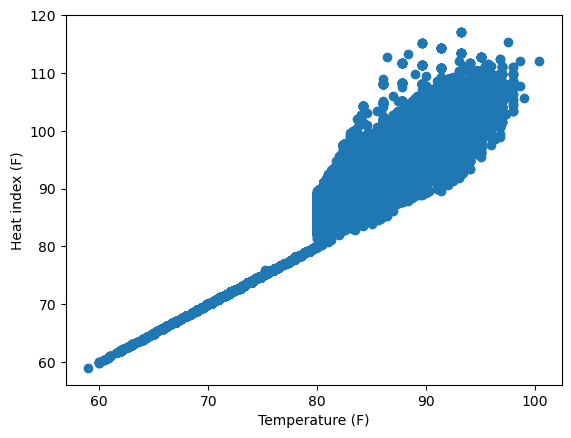

In [13]:
plt.scatter(input_data_nona['tmpf'], input_data_nona['feel'])
plt.xlabel("Temperature (F)")
plt.ylabel("Heat index (F)")

In [14]:
def nws_heat_index(T, RH):
    '''
    T in fahrenheit, RH in %
    https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
    '''
    initial_hi =  0.5 * (T + 61.0 + ((T-68.0)*1.2) + (RH*0.094))
    if initial_hi < 80:
        return initial_hi

    adjustment_factor = 0
    if T>=80 and T<=112 and RH <13:
        adjustment_factor =  ((13-RH)/4)*np.sqrt((17-np.abs(T-95.))/17)
    
    if T>=80 and T<=87 and RH > 85:
         adjustment_factor = ((RH-85)/10) * ((87-T)/5)

    return (-42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - 
           .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH) + adjustment_factor

nws_heat_index_vectorized = np.vectorize(nws_heat_index)

In [15]:
our_calc_hi = nws_heat_index_vectorized(input_data_nona['tmpf'], input_data_nona['relh'])

Text(0, 0.5, 'IEM Reported Feels Like')

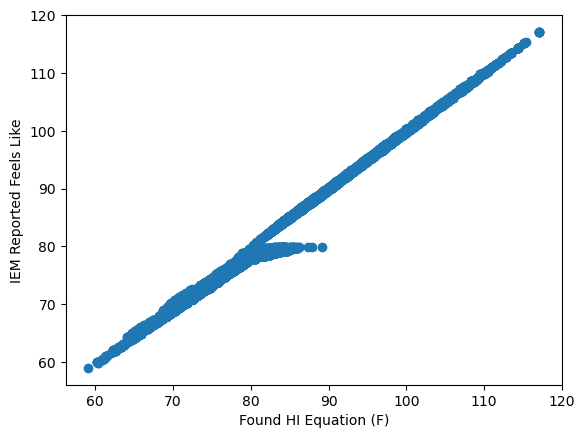

In [16]:
plt.scatter(our_calc_hi, input_data_nona['feel'])
plt.xlabel("Found HI Equation (F)")
plt.ylabel("IEM Reported Feels Like")

(80.0, 120.0)

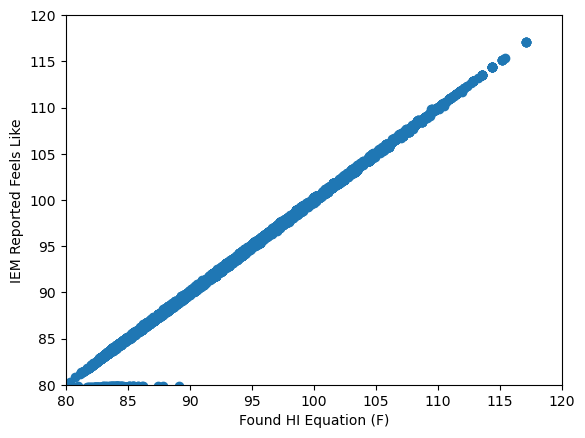

In [17]:
plt.scatter(our_calc_hi, input_data_nona['feel'])
plt.xlabel("Found HI Equation (F)")
plt.ylabel("IEM Reported Feels Like")
plt.xlim(80, 120)
plt.ylim(80, 120)

Let's try this with an ANN

In [20]:
from sklearn.model_selection import train_test_split

In [33]:
# Prepare our data first
training_data, test_validation = train_test_split(input_data_nona, test_size=0.25)
testing_data, validation_data = train_test_split(test_validation, test_size=0.5)

In [42]:
training_data['tmpf'].values.shape

(45764,)

In [34]:
np.sum(pd.isna(training_data['tmpf'].values))

0

In [52]:
# Let's try adding different layers
input_temp = keras.layers.Input(shape=(1, ))
input_rh = keras.layers.Input(shape=(1,))
temp_norm = keras.layers.Normalization()(input_temp)
rh_norm = keras.layers.Normalization()(input_rh)
combined_layer = keras.layers.Concatenate()([temp_norm, rh_norm])


dense1 = keras.layers.Dense(128, input_dim=1, activation=keras.activations.sigmoid)(combined_layer)
dense2 = keras.layers.Dense(128, input_dim=1, activation=keras.activations.relu)(dense1)

output = keras.layers.Dense(1, activation=keras.activations.relu, use_bias=True)(dense2)
model = keras.models.Model(inputs=[input_temp, input_rh], outputs=[output])
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01), loss='mean_squared_error')
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 normalization_12 (Normaliz  (None, 1)                    3         ['input_13[0][0]']            
 ation)                                                                                           
                                                                                                  
 normalization_13 (Normaliz  (None, 1)                    3         ['input_14[0][0]']      

In [53]:
model.fit([training_data['tmpf'].values,training_data['relh'].values ], 
           training_data['feel'].values, epochs=8, 
            validation_data=([validation_data['tmpf'].values,validation_data['relh'].values ], 
           validation_data['feel'].values),
            batch_size=64)

Epoch 1/8
716/716 [==============================] - 4s 5ms/step - loss: 89.6771 - val_loss: 29.1754
Epoch 2/8
716/716 [==============================] - 3s 5ms/step - loss: 29.3000 - val_loss: 30.2692
Epoch 3/8
716/716 [==============================] - 3s 5ms/step - loss: 29.9561 - val_loss: 48.3930
Epoch 4/8
716/716 [==============================] - 3s 5ms/step - loss: 29.6211 - val_loss: 29.3704
Epoch 5/8
716/716 [==============================] - 4s 5ms/step - loss: 29.2519 - val_loss: 28.5945
Epoch 6/8
716/716 [==============================] - 4s 5ms/step - loss: 28.6397 - val_loss: 28.6467
Epoch 7/8
716/716 [==============================] - 3s 5ms/step - loss: 28.5626 - val_loss: 32.5342
Epoch 8/8
716/716 [==============================] - 3s 5ms/step - loss: 28.0165 - val_loss: 29.7300


In [54]:
model.evaluate([testing_data['tmpf'].values,testing_data['relh'].values ], testing_data['feel'].values)

239/239 [==============================] - 1s 3ms/step - loss: 28.7309


28.73090362548828

In [55]:
predicted_hi = model.predict([testing_data['tmpf'].values,testing_data['relh'].values ])

239/239 [==============================] - 0s 2ms/step


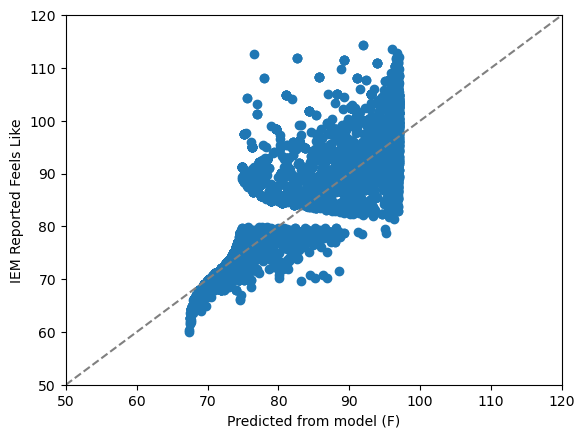

In [56]:
plt.scatter(predicted_hi, testing_data['feel'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("IEM Reported Feels Like")
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')

In [45]:
model.save("my_model.keras")

In [48]:
reloaded_model = tf.keras.saving.load_model("my_model.keras")

In [49]:
reloaded_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 normalization_8 (Normaliza  (None, 1)                    3         ['input_9[0][0]']             
 tion)                                                                                            
                                                                                                  
 normalization_9 (Normaliza  (None, 1)                    3         ['input_10[0][0]']      

Custom Loss Functions need to be differentiable and need to use tensorflow functions. 

In [57]:
def loss_MSE(y_true, y_pred):
   return tf.math.reduce_mean(tf.square(y_true - y_pred))

In [58]:
# Let's try adding different layers
input_temp = keras.layers.Input(shape=(1, ))
input_rh = keras.layers.Input(shape=(1,))
temp_norm = keras.layers.Normalization()(input_temp)
rh_norm = keras.layers.Normalization()(input_rh)
combined_layer = keras.layers.Concatenate()([temp_norm, rh_norm])


dense1 = keras.layers.Dense(128, input_dim=1, activation=keras.activations.sigmoid)(combined_layer)

output = keras.layers.Dense(1, activation=keras.activations.relu, use_bias=True)(dense1)
model = keras.models.Model(inputs=[input_temp, input_rh], outputs=[output])
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01), loss=loss_MSE)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 normalization_14 (Normaliz  (None, 1)                    3         ['input_15[0][0]']            
 ation)                                                                                           
                                                                                                  
 normalization_15 (Normaliz  (None, 1)                    3         ['input_16[0][0]']      

In [59]:
model.fit([training_data['tmpf'].values,training_data['relh'].values ], 
           training_data['feel'].values, epochs=8, 
            validation_data=([validation_data['tmpf'].values,validation_data['relh'].values ], 
           validation_data['feel'].values),
            batch_size=64)

Epoch 1/8
716/716 [==============================] - 4s 4ms/step - loss: 7208.1938 - val_loss: 7170.4556
Epoch 2/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1924 - val_loss: 7170.4556
Epoch 3/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1865 - val_loss: 7170.4556
Epoch 4/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1938 - val_loss: 7170.4556
Epoch 5/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1904 - val_loss: 7170.4556
Epoch 6/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1919 - val_loss: 7170.4556
Epoch 7/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1904 - val_loss: 7170.4556
Epoch 8/8
716/716 [==============================] - 3s 4ms/step - loss: 7208.1904 - val_loss: 7170.4556


In [60]:
# Loss function with weights based on amplitude of y_true
# Adapted from the CIRA guide to custom loss functions
def my_MSE_weighted(y_true,y_pred):
   return tf.keras.mean(
       tf.multiply(
           tf.exp(tf.multiply(5.0, y_true)),
           tf.square(tf.subtract(y_pred, y_true))
       )
)

In [61]:
# Let's try adding different layers
input_temp = keras.layers.Input(shape=(1, ))
input_rh = keras.layers.Input(shape=(1,))
temp_norm = keras.layers.Normalization()(input_temp)
rh_norm = keras.layers.Normalization()(input_rh)
combined_layer = keras.layers.Concatenate()([temp_norm, rh_norm])


dense1 = keras.layers.Dense(128, input_dim=1, activation=keras.activations.sigmoid)(combined_layer)

output = keras.layers.Dense(1, activation=keras.activations.relu, use_bias=True)(dense1)
model = keras.models.Model(inputs=[input_temp, input_rh], outputs=[output])
model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=0.01), loss=loss_MSE)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 normalization_16 (Normaliz  (None, 1)                    3         ['input_17[0][0]']            
 ation)                                                                                           
                                                                                                  
 normalization_17 (Normaliz  (None, 1)                    3         ['input_18[0][0]']      

In [62]:
model.fit([training_data['tmpf'].values,training_data['relh'].values ], 
           training_data['feel'].values, epochs=8, 
            validation_data=([validation_data['tmpf'].values,validation_data['relh'].values ], 
           validation_data['feel'].values),
            batch_size=64)

Epoch 1/8
716/716 [==============================] - 3s 4ms/step - loss: 410.4821 - val_loss: 119.0755
Epoch 2/8
716/716 [==============================] - 3s 4ms/step - loss: 60.7200 - val_loss: 39.5156
Epoch 3/8
716/716 [==============================] - 3s 4ms/step - loss: 34.5097 - val_loss: 32.9968
Epoch 4/8
716/716 [==============================] - 3s 4ms/step - loss: 32.1864 - val_loss: 32.2416
Epoch 5/8
716/716 [==============================] - 3s 4ms/step - loss: 31.4600 - val_loss: 31.8930
Epoch 6/8
716/716 [==============================] - 3s 4ms/step - loss: 30.1959 - val_loss: 30.3143
Epoch 7/8
716/716 [==============================] - 3s 4ms/step - loss: 29.4608 - val_loss: 28.7515
Epoch 8/8
716/716 [==============================] - 3s 4ms/step - loss: 27.9892 - val_loss: 27.8303


In [63]:
predicted_hi = model.predict([testing_data['tmpf'].values,testing_data['relh'].values ])

239/239 [==============================] - 0s 2ms/step


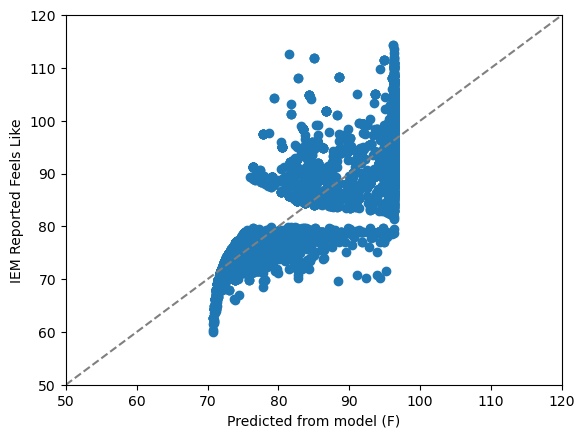

In [64]:
plt.scatter(predicted_hi, testing_data['feel'])
plt.xlabel("Predicted from model (F)")
plt.ylabel("IEM Reported Feels Like")
plt.xlim(50, 120)
plt.ylim(50, 120)
plt.plot([50, 120], [50, 120], color='grey', ls='--')